In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
# Download latest version
path = kagglehub.dataset_download("netflix-inc/netflix-prize-data")

print("Path to dataset folder:", path)

d:\Btech sem 4 2024-28\Machine Learning\NetflixRec\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset folder: C:\Users\Nirmal Choyal\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2


In [28]:
# import necessary libraries
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from scipy.sparse import coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares


In [4]:
# List files in the dataset folder
print("\nFiles inside dataset folder:")
print(os.listdir(path))


Files inside dataset folder:
['combined_data_1.txt', 'combined_data_2.txt', 'combined_data_3.txt', 'combined_data_4.txt', 'movie_titles.csv', 'probe.txt', 'qualifying.txt', 'README']


In [5]:
# Read and display the first 5 lines of combined_data_1.txt 
file_path = os.path.join(path, "combined_data_1.txt")
print(f"\nFirst 5 lines of {file_path}:")
with open(file_path, "r") as f:
    for _ in range(5):
        print(f.readline().strip())


First 5 lines of C:\Users\Nirmal Choyal\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2\combined_data_1.txt:
1:
1488844,3,2005-09-06
822109,5,2005-05-13
885013,4,2005-10-19
30878,4,2005-12-26


In [6]:
# Read movie titles from movie_titles.csv
path1 = os.path.join(path, "movie_titles.csv")

rows = []
with open(path1, "r", encoding="latin-1") as f:
    reader = csv.reader(f)
    for row in reader:
        movie_id = int(row[0])
        year = row[1] if row[1] != "" else None
        title = ",".join(row[2:])   # join remaining parts safely
        rows.append([movie_id, year, title])

movies = pd.DataFrame(rows, columns=["MovieID", "Year", "Title"])
movies.head()


,MovieID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


## Creating subset of the netflix dataset

In [7]:
# Count number of ratings per user and per movie
combined_files = [
    os.path.join(path, "combined_data_1.txt"),
    os.path.join(path, "combined_data_2.txt"),
    os.path.join(path, "combined_data_3.txt"),
    os.path.join(path, "combined_data_4.txt"),
]

user_count = defaultdict(int) # user_id -> count of ratings
movie_count = defaultdict(int)

movie_id = None

for file_path in combined_files:
    print("Reading:", file_path)

    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()

            if line.endswith(":"):
                movie_id = int(line[:-1]) # remove trailing ":"
            else:
                user_id = int(line.split(",")[0])
                user_count[user_id] += 1
                movie_count[movie_id] += 1

Reading: C:\Users\Nirmal Choyal\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2\combined_data_1.txt
Reading: C:\Users\Nirmal Choyal\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2\combined_data_2.txt
Reading: C:\Users\Nirmal Choyal\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2\combined_data_3.txt
Reading: C:\Users\Nirmal Choyal\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2\combined_data_4.txt


In [8]:
# Get top 10,000 users and top 1,000 movies by rating count
top_users = sorted(user_count.items(), key=lambda x: x[1], reverse=True)[:10000]
top_movies = sorted(movie_count.items(), key=lambda x: x[1], reverse=True)[:1000]

top_users_set = set([u for u, c in top_users])
top_movies_set = set([m for m, c in top_movies])

print("Top user sample:", list(top_users_set)[:5])
print("Top movie sample:", list(top_movies_set)[:5])


Top user sample: [983042, 1933317, 524295, 2424839, 393226]
Top movie sample: [16384, 10241, 12293, 16390, 12299]


In [9]:
# Filter ratings to only include those from top users and for top movies
rows = []
movie_id = None

for file_path in combined_files:
    print("Filtering:", file_path)

    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()

            if line.endswith(":"):
                movie_id = int(line[:-1])
            else:
                user_id, rating, date = line.split(",")
                user_id = int(user_id)

                if (user_id in top_users_set) and (movie_id in top_movies_set):
                    rows.append([user_id, movie_id, int(rating), date])

final_df = pd.DataFrame(rows, columns=["UserID", "MovieID", "Rating", "Date"])

print(final_df.shape)
print("Users:", final_df["UserID"].nunique())
print("Movies:", final_df["MovieID"].nunique())



Filtering: C:\Users\Nirmal Choyal\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2\combined_data_1.txt
Filtering: C:\Users\Nirmal Choyal\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2\combined_data_2.txt
Filtering: C:\Users\Nirmal Choyal\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2\combined_data_3.txt
Filtering: C:\Users\Nirmal Choyal\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2\combined_data_4.txt
(6264274, 4)
Users: 10000
Movies: 1000


In [10]:
final_df.head()

,UserID,MovieID,Rating,Date
0,1990901,28,5,2004-02-16
1,765331,28,3,2003-03-20
2,1987434,28,4,2005-07-14
3,2193455,28,4,2005-01-19
4,1468812,28,4,2003-01-14


In [11]:
final_df.to_csv("netflix_subset_10k_users_1k_movies.csv", index=False)
print("Saved:", final_df.shape)


Saved: (6264274, 4)


In [12]:
# Read movie titles again to merge with ratings
titles_path = os.path.join(path, "movie_titles.csv")

rows = []
with open(titles_path, "r", encoding="latin-1") as f:
    reader = csv.reader(f)
    for row in reader:
        movie_id = int(row[0])
        year = row[1] if row[1] != "" else None
        title = ",".join(row[2:])
        rows.append([movie_id, year, title])

movies = pd.DataFrame(rows, columns=["MovieID", "Year", "Title"])
    
final_merged = final_df.merge(movies, on="MovieID", how="left")
final_merged.head()


,UserID,MovieID,Rating,Date,Year,Title
0,1990901,28,5,2004-02-16,2002,Lilo and Stitch
1,765331,28,3,2003-03-20,2002,Lilo and Stitch
2,1987434,28,4,2005-07-14,2002,Lilo and Stitch
3,2193455,28,4,2005-01-19,2002,Lilo and Stitch
4,1468812,28,4,2003-01-14,2002,Lilo and Stitch


In [13]:
print("Users:", final_merged["UserID"].nunique())
print("Movies:", final_merged["MovieID"].nunique())
print(final_merged.isna().sum())


Users: 10000
Movies: 1000
UserID     0
MovieID    0
Rating     0
Date       0
Year       0
Title      0
dtype: int64


In [14]:
print("Rows:", final_merged.shape[0])
print("Users:", final_merged["UserID"].nunique())
print("Movies:", final_merged["MovieID"].nunique())
print("Rating range:", final_merged["Rating"].min(), "-", final_merged["Rating"].max())
print("Date range:", final_merged["Date"].min(), "to", final_merged["Date"].max())


Rows: 6264274
Users: 10000
Movies: 1000
Rating range: 1 - 5
Date range: 1999-12-21 to 2005-12-31


# EDA


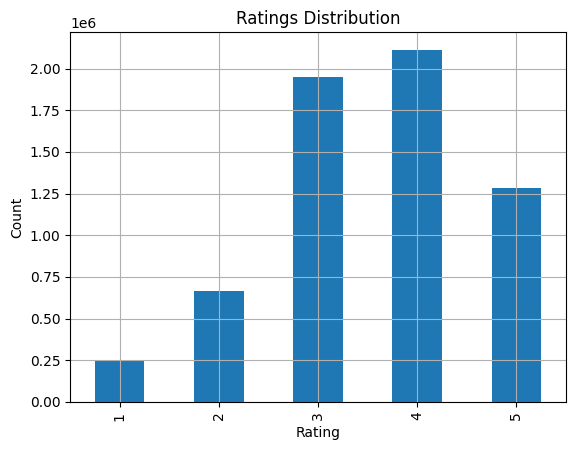

In [15]:
final_merged["Rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.show()

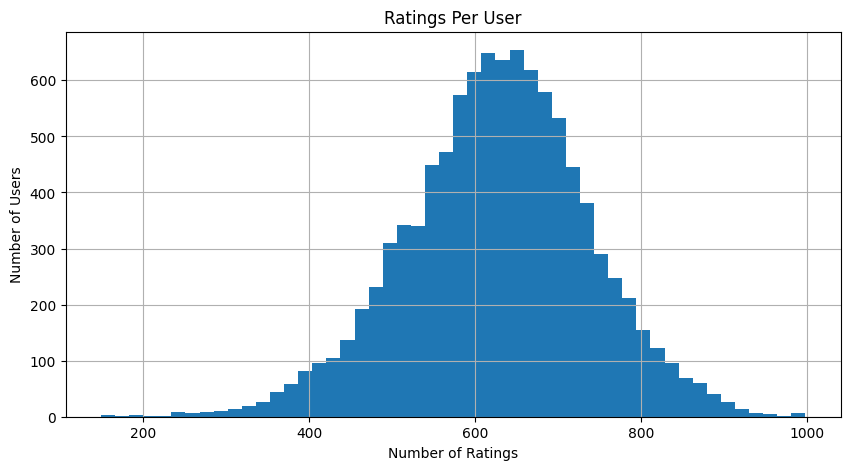

User ratings summary:
count    10000.000000
mean       626.427400
std        110.904204
min        149.000000
25%        557.000000
50%        630.000000
75%        699.000000
max        998.000000
Name: Rating, dtype: float64


In [16]:
ratings_per_user = final_merged.groupby("UserID")["Rating"].count()

plt.figure(figsize=(10,5))
plt.hist(ratings_per_user, bins=50)
plt.title("Ratings Per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

print("User ratings summary:")
print(ratings_per_user.describe())


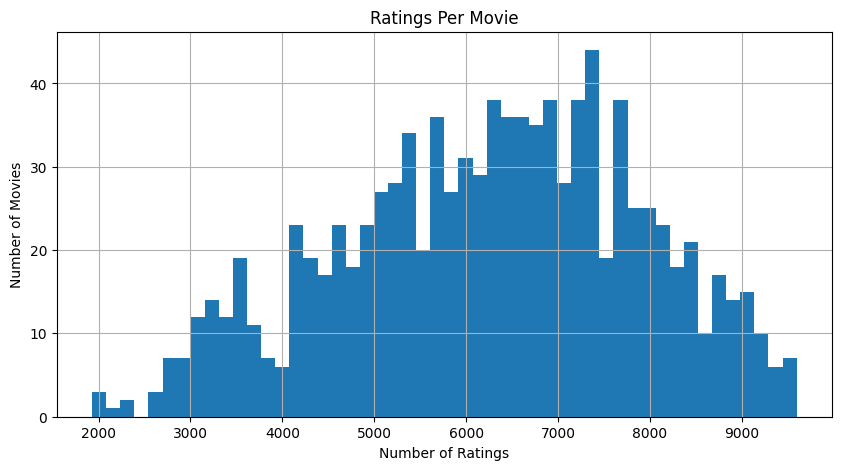

Movie ratings summary:
count    1000.000000
mean     6264.274000
std      1634.201606
min      1930.000000
25%      5138.000000
50%      6381.000000
75%      7438.250000
max      9596.000000
Name: Rating, dtype: float64


In [17]:
ratings_per_movie = final_merged.groupby("MovieID")["Rating"].count()

plt.figure(figsize=(10,5))
plt.hist(ratings_per_movie, bins=50)
plt.title("Ratings Per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()

print("Movie ratings summary:")
print(ratings_per_movie.describe())


In [18]:
num_users = final_merged["UserID"].nunique()
num_movies = final_merged["MovieID"].nunique()
num_ratings = final_merged.shape[0]

sparsity = 1 - (num_ratings / (num_users * num_movies))
print("Matrix Sparsity:", sparsity)


Matrix Sparsity: 0.37357260000000003


In [19]:

df = final_merged.copy()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train:", train_df.shape)
print("Test:", test_df.shape)

Train: (5011419, 6)
Test: (1252855, 6)


In [20]:
mu = train_df["Rating"].mean()
mu


np.float64(3.559011529468999)

In [21]:
lambda_reg = 10  # you can tune this later

# Movie bias
movie_stats = train_df.groupby("MovieID")["Rating"].agg(["mean", "count"])
movie_bias = (movie_stats["mean"] - mu) * (movie_stats["count"] / (movie_stats["count"] + lambda_reg))

# User bias
user_stats = train_df.groupby("UserID")["Rating"].agg(["mean", "count"])
user_bias = (user_stats["mean"] - mu) * (user_stats["count"] / (user_stats["count"] + lambda_reg))

print("Movies in train:", len(movie_bias))
print("Users in train:", len(user_bias))


Movies in train: 1000
Users in train: 10000


In [22]:
def predict_baseline(row):
    u = row["UserID"]
    m = row["MovieID"]
    
    bu = user_bias.get(u, 0)
    bi = movie_bias.get(m, 0)
    
    pred = mu + bu + bi
    
    # ratings must be 1–5
    return min(5, max(1, pred))

test_df["Pred_Baseline"] = test_df.apply(predict_baseline, axis=1)
test_df[["UserID", "MovieID", "Rating", "Pred_Baseline"]].head()


,UserID,MovieID,Rating,Pred_Baseline
3313382,2388250,9768,5,3.515397
4217305,1252521,12497,5,3.324321
5087383,1409759,14702,5,3.806405
5929746,798262,16879,3,3.249094
3111561,649547,9049,2,3.330353


In [23]:
rmse = np.sqrt(mean_squared_error(test_df["Rating"], test_df["Pred_Baseline"]))
print("Baseline Model RMSE:", rmse)


Baseline Model RMSE: 0.9022005543677473


In [24]:
test_df["Pred_GlobalMean"] = mu
rmse_global = np.sqrt(mean_squared_error(test_df["Rating"], test_df["Pred_GlobalMean"]))

print("Global Mean RMSE:", rmse_global)
print("Baseline Improvement:", rmse_global - rmse)


Global Mean RMSE: 1.05292214872721
Baseline Improvement: 0.15072159435946275


In [25]:
results = pd.DataFrame({
    "Model": ["Global Mean", "Baseline (mu + bu + bi)"],
    "RMSE": [rmse_global, rmse]
})

results


,Model,RMSE
0,Global Mean,1.052922
1,Baseline (mu + bu + bi),0.902201


In [26]:

def compute_biases(train, lambda_reg):
    mu = train["Rating"].mean()
    # movie bias
    movie_stats = train.groupby("MovieID")["Rating"].agg(["sum","count"])
    bi = (movie_stats["sum"] - movie_stats["count"] * mu) / (movie_stats["count"] + lambda_reg)
    # user bias (use movie bias-adjusted residuals)
    train_adj = train.join(bi.rename("bi"), on="MovieID")
    train_adj["resid"] = train_adj["Rating"] - mu - train_adj["bi"]
    user_stats = train_adj.groupby("UserID")["resid"].agg(["sum","count"])
    bu = user_stats["sum"] / (user_stats["count"] + lambda_reg)
    return mu, bu.to_dict(), bi.to_dict()

def rmse_with_lambda(train, val, lambda_reg):
    mu, bu, bi = compute_biases(train, lambda_reg)
    def pred(row):
        return min(5, max(1, mu + bu.get(row.UserID,0) + bi.get(row.MovieID,0)))
    preds = val.apply(pred, axis=1)
    return np.sqrt(mean_squared_error(val["Rating"], preds))

# grid search
lambdas = [0, 1, 3, 5, 10, 20, 40, 80]
results = []
for l in tqdm(lambdas):
    rmse = rmse_with_lambda(train_df, test_df, l)
    results.append((l, rmse))

pd.DataFrame(results, columns=["lambda","rmse"]).sort_values("rmse")


100%|██████████| 8/8 [03:22<00:00, 25.29s/it]


,lambda,rmse
0,0,0.901272
1,1,0.901276
2,3,0.901286
3,5,0.901299
4,10,0.901344
5,20,0.901487
6,40,0.901954
7,80,0.903421


In [31]:
# ALS: training + RMSE + Precision@K 

# 1) Prepare train/test (by interactions)
df = final_merged.copy()                  # your cleaned subset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 2) Build mappings using TRAIN only (avoid leakage)
user_ids = train_df["UserID"].unique()
movie_ids = train_df["MovieID"].unique()
user_map = {u:i for i,u in enumerate(user_ids)}
movie_map = {m:i for i,m in enumerate(movie_ids)}

train_df["u"] = train_df["UserID"].map(user_map)
train_df["i"] = train_df["MovieID"].map(movie_map)

# Filter test rows to those present in the training maps
test_df = test_df[
    test_df["UserID"].isin(user_map) & test_df["MovieID"].isin(movie_map)
].copy()
test_df["u"] = test_df["UserID"].map(user_map)
test_df["i"] = test_df["MovieID"].map(movie_map)

# 3) Build item-user sparse matrix (items x users) - implicit expects this orientation
train_mat = coo_matrix(
    (train_df["Rating"].astype(float), (train_df["i"], train_df["u"]))
).tocsr()



In [32]:
# Quick checks
print("Train matrix shape (items x users):", train_mat.shape)
print("Non-zero entries:", train_mat.nnz)
print("Density:", train_mat.nnz / (train_mat.shape[0] * train_mat.shape[1]))



Train matrix shape (items x users): (1000, 10000)
Non-zero entries: 5011419
Density: 0.5011419


In [33]:
# 4) Train ALS
als = AlternatingLeastSquares(factors=50, regularization=0.05, iterations=20, random_state=42)
# implicit expects confidence weights; using raw ratings is acceptable for a case study
als.fit(train_mat)



100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


In [35]:
# 5) RMSE on test interactions
def predict_rating(u_idx, i_idx):
    return float(np.dot(als.user_factors[u_idx], als.item_factors[i_idx]))

preds = []
actual = []
for row in test_df.itertuples(index=False):
    u = int(row.u)
    i = int(row.i)
    r = float(row.Rating)
    p = predict_rating(u, i)
    p = min(5.0, max(1.0, p))   # clip to rating bounds for RMSE comparability
    preds.append(p)
    actual.append(r)

rmse_als = np.sqrt(mean_squared_error(actual, preds))
print("ALS RMSE (clipped 1-5):", rmse_als)

IndexError: index 4553 is out of bounds for axis 0 with size 1000

In [ ]:
# 6) Top-K evaluation (Precision@K, Recall@K)
K = 10
threshold = 4.0   # consider ratings >= 4 as relevant

# ground truth relevant items per user in test set
test_relevant = test_df[test_df["Rating"] >= threshold].groupby("u")["i"].apply(set).to_dict()

# user-items train matrix (users x items) used to filter already-seen items
train_user_items = train_mat.T.tocsr()

def precision_recall_at_k(model, train_user_items, test_relevant, K=10):
    precisions = []
    recalls = []
    for u, relevant in test_relevant.items():
        if len(relevant) == 0:
            continue
        recs, scores = model.recommend(userid=u, user_items=train_user_items, N=K, filter_already_liked_items=True)
        recs_set = set(recs)
        hits = len(recs_set & relevant)
        precisions.append(hits / K)
        recalls.append(hits / len(relevant))
    return float(np.mean(precisions)), float(np.mean(recalls))

precision_k, recall_k = precision_recall_at_k(als, train_user_items, test_relevant, K=K)
print(f"Precision@{K}: {precision_k:.4f}")
print(f"Recall@{K}:    {recall_k:.4f}")

# 7) (Optional) sample recommendations for one train user index
idx_to_movie = {idx: mid for mid, idx in movie_map.items()}
sample_u = list(test_relevant.keys())[0]
recs, scores = als.recommend(userid=sample_u, user_items=train_user_items, N=10, filter_already_liked_items=True)
print("Sample user index:", sample_u)
print("Recommended movieIDs (indices->original IDs):", [idx_to_movie[i] for i in recs])